In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [ ]:
def load_from_path(data_path: Path):
    crop_perfs = []

    for mode in ["attention", "max_pooler"]:
        train_metrics = pd.read_csv(
            data_path / ("mode=" + mode) / "combined_model" / "final_train_metrics.csv"
        )
        mode_string = mode.replace("_", " ").title()
        for i, row in train_metrics.iterrows():
            crop = row['crop_slug'].replace("_", " ").title()
            crop_perfs.append(
                {
                    "title": f"{crop} ({mode_string} combined)",
                    "crop": crop,
                    "presence_f1": row["presence_f1"],
                    "rmse_if_present": row["rmse_if_present"],
                    "pooling_method": mode,
                    "training_method": "combined",
                }
            )

        single_models_path = data_path / ("mode=" + mode) / "single_models"
        for single_model_path in single_models_path.iterdir():
            train_metrics = pd.read_csv(single_model_path / "final_train_metrics.csv")

            row = train_metrics.iloc[0]
            crop = row['crop_slug'].replace("_", " ").title()
            crop_perfs.append(
                {
                    "title": f"{crop} ({mode_string} single)",
                    "crop": crop,
                    "presence_f1": row["presence_f1"],
                    "rmse_if_present": row["rmse_if_present"],
                    "pooling_method": mode,
                    "training_method": "single",
                }
            )

crop_perfs = pd.DataFrame(load_from_path(Path("../out/2024-11-24_08-10-20")))

In [ ]:
# Plot the performance by method
sns.set_theme(context="notebook", style="whitegrid")

sns.barplot(data=crop_perfs, x='title', y='presence_f1', hue='training_method')
plt.xticks(rotation=90)

plt.show()


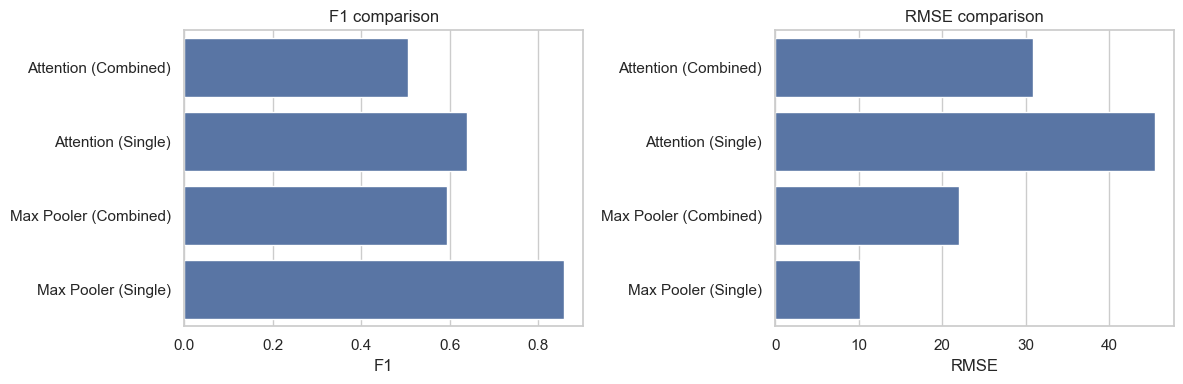

In [50]:
# compare average f1 for each approach

approach_scores = []

for pooling_method_name, pooling_method_df in crop_perfs.groupby("pooling_method"):
    for training_method_name, training_method_df in pooling_method_df.groupby(
        "training_method"
    ):
        result = training_method_df[["presence_f1", "rmse_if_present"]].mean(axis=0)
        title = f"{pooling_method_name} ({training_method_name})"
        title = title.replace("_", " ").title()
        approach_scores.append(
            {
                "title": title,
                "pooling_method": pooling_method_name,
                "training_method": training_method_name,
                "presence_f1": result["presence_f1"],
                "rmse": result["rmse_if_present"],
            }
        )

approach_scores = pd.DataFrame(approach_scores)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("F1 comparison")
sns.barplot(approach_scores, y='title', x='presence_f1', orient='h')
plt.xlabel("F1")
plt.ylabel("")

plt.subplot(1, 2, 2)
plt.title("RMSE comparison")
sns.barplot(approach_scores, y='title', x='rmse', orient='h')
plt.xlabel("RMSE")
plt.ylabel("")
plt.tight_layout()

plt.show()

In [25]:
approach_scores

,title,pooling_method,training_method,presence_f1,rmse
0,Attention (Combined),attention,combined,0.506453,30.883118
1,Attention (Single),attention,single,0.639252,45.475485
2,Max Pooler (Combined),max_pooler,combined,0.594193,22.013082
3,Max Pooler (Single),max_pooler,single,0.858410,10.116599


## Plotting Per-Crop Performance

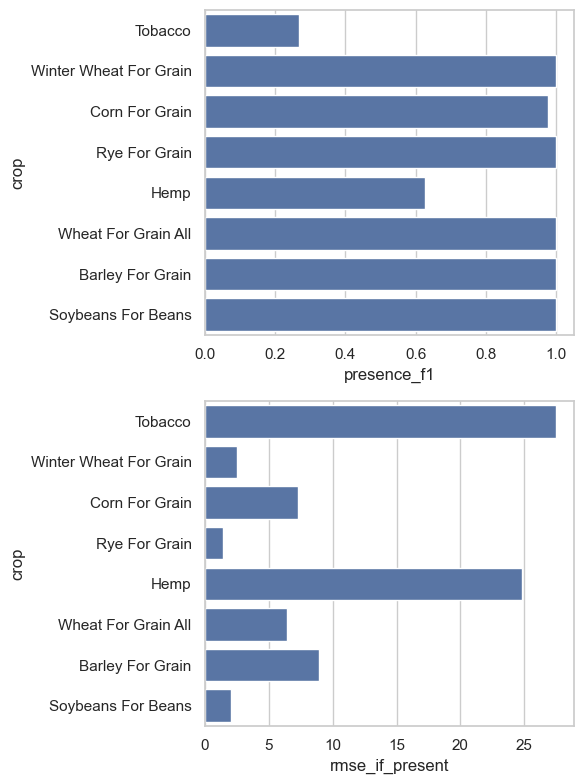

In [55]:
max_pooler_single = crop_perfs[(crop_perfs['pooling_method'] == 'max_pooler') & (crop_perfs['training_method'] == 'single')]
max_pooler_single.loc[:, 'crop'] = max_pooler_single['crop'].map(lambda c: 'Hemp' if 'Hemp' in c else c)

plt.subplots(2, 1, figsize=(6, 8))
plt.subplot(2, 1, 1)
sns.barplot(
    max_pooler_single,
    x='presence_f1',
    y='crop',
    orient='h',
)
plt.subplot(2, 1, 2)
sns.barplot(
    max_pooler_single,
    x='rmse_if_present',
    y='crop',
    orient='h',
)
plt.tight_layout()
plt.show()
